# Price Prediction for ecommerce products
## Machine Learning Engineer Nanodegree
#### MANCEÑIDO AGUSTIN, 02/2019.

<img src="img/bkgr.jpg" alt="Backgroud" style="width: 100%;"/>

Brand manufacturers should constantly look to evaluate their pricing, learn what works, and make improvements. If the price is too low, you run the risk of not being able to obtain a healthy profit. On the other hand, if the price is too high and you run the risk of not making any sale. **Optimal pricing** is as much art as it is science, and it can mean the difference between an avalanche of orders flowing out or a mountain of excess stock sitting somewhere. Pricing products and services online is one of the most exciting and complex exercises and, as an online business, finding the right formula is one of the most important questions to solve

For this project a **dataset of historical sells of an e-commerce site** will be used to develop an algorithm to **predict the optimal** competitive price for a new product to be published. The algorithm needs to determine what is the relevant data in order to get the best prediction for the price taking into account seasonal prices, market fluctuations, economic trends, better sellers, etc.

>**Notes:** 
* For the complete analysis of the dataset and the feature engineering that is used in this document, please refer to the [Capstone exploration](https://machinelearningmastery.com/persistence-time-series-forecasting-with-python/) file.
* For the bechmarks models used as baseline for this project, please refer to the [Capstone benchmarks](https://machinelearningmastery.com/persistence-time-series-forecasting-with-python/) file. 

### Contents

* [Step 0](#step0): Import libraries & Load dataset
* [Step 1](#step1): Feature Engineering
* [Step 2](#step2): Split data
* [Step 3](#step3): Keras model
* [Step 4](#step4): Make predictions and test
* [Step 5](#step5): K-Fold cross validation
* [Step 6](#step6): Results

---
<a id='step0'></a>
## Step 0: Import libraries & Load dataset

In [1]:
### Import libraries

## General
import numpy as np
import pandas as pd
from time import time
import math
from ast import literal_eval

## Plot
import IPython
import keras
from IPython.display import display

## Scikit-learn
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_log_error

## Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model

## elapsed time
t_start = time()
def print_elapsed(text=''):
    took = (time() - t_start) / 60.0
    print('==== "%s" elapsed %.3f minutes' % (text, took))

Using TensorFlow backend.


In [2]:
# Load dataset
try:
    data = pd.read_csv("database_eng.csv")
    print("Dataset has {} samples with {} features each.".format(*data.shape))
    print_elapsed('dataset loaded')
except:
    print("Dataset could not be loaded. Is the dataset missing?")

display(data.head(n = 3))

Dataset has 788642 samples with 8 features each.
==== "dataset loaded" elapsed 0.014 minutes


,price,weekday,day,week,hour,title_len,state_city,seq_title
0,6.685848,4,17,11,16,9,1038,"[41, 1, 57, 59, 18, 4, 159, 224]"
1,6.685848,4,17,11,16,9,1038,"[41, 1, 57, 59, 18, 4, 159, 224]"
2,6.685848,4,17,11,18,10,1038,"[41, 1, 57, 59, 18, 4, 159, 940]"


The **dataset** to be used on this project has been collected from an Argentine ecommerce site using the official API It consists 795295 records of sells with with 8 features each, all taken between 03/17/2017 and 05/10/2018. The following features are included:
* **title**: name of the product provided by the seller.
* **sellerid**: unique id for each seller.
* **state / city**: seller location.
* **pos**: position where the product was found in the search.
* **sqty**: number of products selled.
* **price**: price of the product.
* **created_at**: timestamp for the sell.

---
<a id='step1'></a>
## Step 1: Feature Engineering

**Feature engineering** is the process of using domain knowledge of the data to create features that make machine learning algorithms work. Using the results from the **dataset exploration** the features will be modified to increase the predictive power of machine learning algorithm by creating features from raw data that help facilitate the machine learning process.

> Dataset is analyzed and modified in the **capstone_exploration** file.

In [3]:
# reading array stored as string
data['seq_title'] = data['seq_title'].apply(literal_eval)

---
<a id='step2'></a>
## Step 2: Split data

In [4]:
# split data
target = data['price']
features = data.drop('price', axis = 1)
f_train, X_test, t_train, y_test = train_test_split(features, target, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(f_train, t_train, random_state=123, train_size=0.99)

print_elapsed('Data split completed')
del target, features

==== "Data split completed" elapsed 0.370 minutes


/home/nitsuga/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [5]:
# Dataset to keras dict
MAX_TITLE = np.max([np.max(data.seq_title.max())])+20
MAX_STATE_CITY = np.max([data.state_city.max()])+1
MAX_TITLE_SEQ = 15

def get_keras_data(dataset):
    X = {
        'weekday':np.array(dataset.weekday),
        'week':np.array(dataset.week),
        'day':np.array(dataset.day),
        'hour':np.array(dataset.hour),
        'title_len':np.array(dataset.title_len),
        'state_city':np.array(dataset.state_city),
        'seq_title': pad_sequences(dataset.seq_title, maxlen=MAX_TITLE_SEQ)
    }
    return X

X_keras_train = get_keras_data(X_train)
X_keras_test = get_keras_data(X_test)
X_keras_valid = get_keras_data(X_valid)

---
<a id='step3'></a>
## Step 3: Keras model

In [6]:
#KERAS MODEL DEFINITION
from keras.layers import Input, Dropout, Dense, Activation, concatenate, Conv1D, GlobalMaxPooling1D, Embedding, Flatten, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K

def get_callbacks(filepath, patience=2):
    # Stop training when a monitored quantity has stopped improving.
    early_stopper = EarlyStopping('val_loss', patience=patience, mode="min")
    # ModelCheckpoint: Save the model after every epoch.
    checkpointer = ModelCheckpoint(filepath=filepath,verbose=1, save_best_only=True)
    
    return [early_stopper, checkpointer]

def get_model():
    
    # Inputs (instantiate a Keras tensor)
    weekday = Input(shape=[1], name="weekday")
    week = Input(shape=[1], name="week")
    day = Input(shape=[1], name="day")
    hour = Input(shape=[1], name="hour")
    title_len = Input(shape=[1], name="title_len")
    state_city = Input(shape=[1], name="state_city")
    seq_title = Input(shape=[X_keras_train["seq_title"].shape[1]], name="seq_title")
    
    # Embeddings layers (Turns into dense vectors of fixed size)
    emb_state_city = Embedding(MAX_STATE_CITY, 20)(state_city)
    emb_seq_title = Embedding(MAX_TITLE, 50)(seq_title)
 
    # Flatten
    flat_layer = Flatten() (emb_state_city)
    
    # CNN layer
    cnn_layer = Conv1D(filters=16, kernel_size=3, activation='relu')(emb_seq_title)
    cnn_layer = GlobalMaxPooling1D()(cnn_layer)
    
    # Concatenate
    concat = concatenate([
        flat_layer
        , cnn_layer
        , weekday
        , week
        , day
        , hour
        , title_len
    ])
    
    # Normalization
    normal_1 = BatchNormalization()(concat)
    
    # Add Densely-connected NN layer + Dropout to prevent overfitting
    dense_1 = Dropout(0.6) (Dense(256, activation="relu") (normal_1))
    dense = Dropout(0.5) (Dense(128, activation="relu") (dense_1))
    
    # Concatenate
    concat_dense = concatenate([
        dense
        , title_len
        , week
        , hour
    ])
    
    # Normalization
    normal_2 = BatchNormalization()(concat_dense)
    
    # Add Densely-connected NN layer + Dropout to prevent overfitting
    dense_final = Dropout(0.3) (Dense(64, activation="relu") (normal_2))
    
    # Set output
    output = Dense(1, activation="linear") (dense_final)
    # Define model
    model = Model([weekday, week, day, hour, title_len, state_city, seq_title], output)
    # Compile model
    model.compile(loss="mean_squared_logarithmic_error", optimizer="adam")
    
    return model

model = get_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_title (InputLayer)          (None, 15)           0                                            
__________________________________________________________________________________________________
state_city (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 15, 50)       1000950     seq_title[0][0]                  
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 20)        36460       state_city[0][0]                 
__________________________________________________________________________________________________
conv1d_1 (

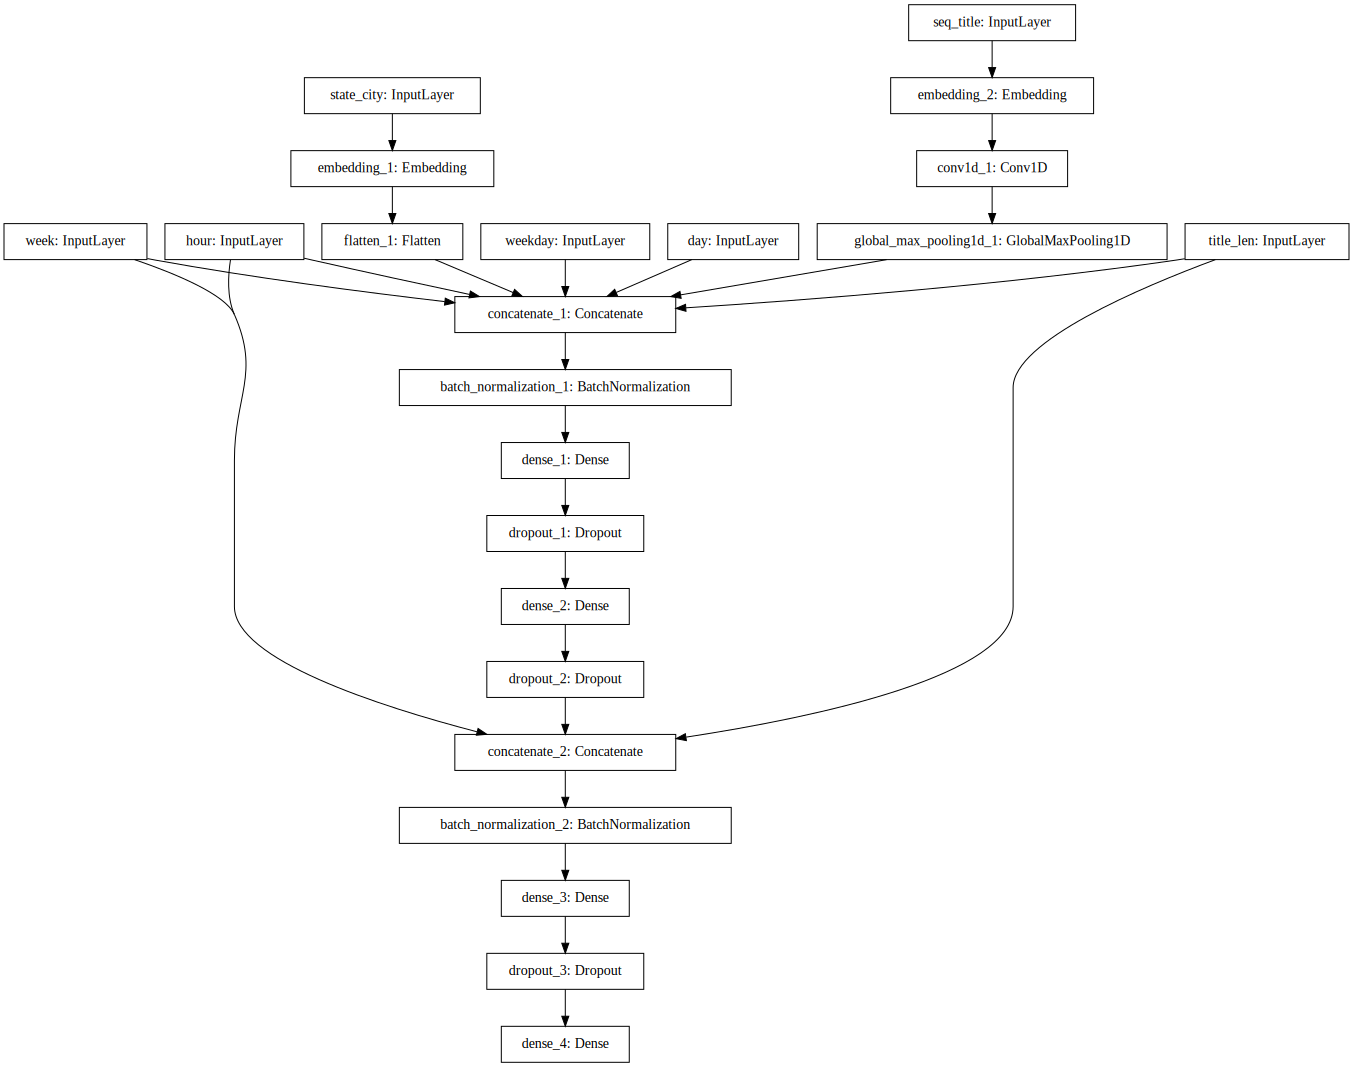

In [7]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
IPython.display.SVG(keras.utils.vis_utils.model_to_dot(model).create(prog='dot', format='svg'))

In [8]:
# Fitting the model
BATCH_SIZE = 100
EPOCHS = 5

model = get_model()

history = model.fit(X_keras_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE
          , validation_data=(X_keras_valid, y_valid)
          , callbacks = get_callbacks('weights.best.hdf5')
          , verbose=1)

Train on 585566 samples, validate on 5915 samples
Epoch 1/5
585566/585566 [==============================] - 183s 313us/step - loss: 0.0519 - val_loss: 0.0091

Epoch 00001: val_loss improved from inf to 0.00909, saving model to weights.best.hdf5
Epoch 2/5
585566/585566 [==============================] - 180s 308us/step - loss: 0.0117 - val_loss: 0.0055

Epoch 00002: val_loss improved from 0.00909 to 0.00548, saving model to weights.best.hdf5
Epoch 3/5
585566/585566 [==============================] - 181s 309us/step - loss: 0.0081 - val_loss: 0.0054

Epoch 00003: val_loss improved from 0.00548 to 0.00535, saving model to weights.best.hdf5
Epoch 4/5
585566/585566 [==============================] - 181s 309us/step - loss: 0.0063 - val_loss: 0.0048

Epoch 00004: val_loss improved from 0.00535 to 0.00480, saving model to weights.best.hdf5
Epoch 5/5
585566/585566 [==============================] - 180s 308us/step - loss: 0.0053 - val_loss: 0.0043

Epoch 00005: val_loss improved from 0.00480 

---
<a id='step4'></a>
## Step 4: Make predictions and test

In [9]:
def evaluate_model(model, X_test, Y_test, BATCH_SIZE):
    # Get predictions
    preds = model.predict(X_test, batch_size=BATCH_SIZE)
    # Shape normalizaition: y_test, preds
    preds = np.asarray(preds, dtype=np.float32)
    # Convert back to real values
    preds = np.exp(preds)
    # Test score
    score = mean_squared_log_error(Y_test, preds)
    return score

In [10]:
# Load best weights from checkpoint
model.load_weights('weights.best.hdf5')

In [11]:
# Shape normalizaition: y_test
y_test = np.asarray(y_test, dtype=np.float32)
y_test = np.exp(y_test)

In [12]:
# Evaluate model
test_score = evaluate_model(model, X_keras_test, y_test, BATCH_SIZE)
print('Test MSLE: %.3f' % test_score)

Test MSLE: 0.109


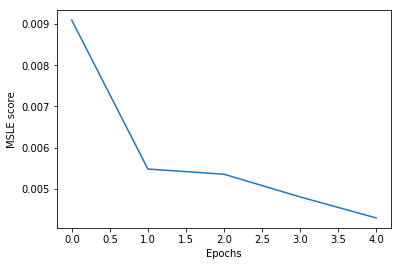

In [16]:
# plot metrics
from matplotlib import pyplot
pyplot.plot(history.history['val_loss'])
pyplot.xlabel('Epochs')
pyplot.ylabel('MSLE score')
pyplot.show()

---
<a id='step5'></a>
## Step 5: K-Fold cross validation

In [14]:
# Set folds and datasets
k = 10
X_train = f_train
y_train = t_train
folds = list(KFold(n_splits=k, shuffle=True, random_state=1).split(X_train, y_train))

In [15]:
# Compile, Fit & evaluate models for each fold
for j, (train_idx, val_idx) in enumerate(folds):
    
    print('Fold %i' % j)
    X_train_cv, X_valid_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_cv, y_valid_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    name_weights = "model_fold" + str(j) + "_weights.h5"
    callbacks = get_callbacks(name_weights)
    model = get_model()
    model.fit(get_keras_data(X_train_cv), y_train_cv
          , epochs=EPOCHS, batch_size=BATCH_SIZE
          , validation_data=(get_keras_data(X_valid_cv), y_valid_cv)
          , callbacks = callbacks
          , verbose=1)
    
    test_score = evaluate_model(model, X_keras_test, y_test, BATCH_SIZE)
    print('Test MSLE: %.3f' % test_score)

Fold 0
Train on 532332 samples, validate on 59149 samples
Epoch 1/5
532332/532332 [==============================] - 169s 317us/step - loss: 0.0532 - val_loss: 0.0070

Epoch 00001: val_loss improved from inf to 0.00704, saving model to model_fold0_weights.h5
Epoch 2/5
532332/532332 [==============================] - 166s 311us/step - loss: 0.0124 - val_loss: 0.0052

Epoch 00002: val_loss improved from 0.00704 to 0.00518, saving model to model_fold0_weights.h5
Epoch 3/5
532332/532332 [==============================] - 166s 312us/step - loss: 0.0084 - val_loss: 0.0037

Epoch 00003: val_loss improved from 0.00518 to 0.00374, saving model to model_fold0_weights.h5
Epoch 4/5
532332/532332 [==============================] - 166s 312us/step - loss: 0.0065 - val_loss: 0.0034

Epoch 00004: val_loss improved from 0.00374 to 0.00338, saving model to model_fold0_weights.h5
Epoch 5/5
532332/532332 [==============================] - 166s 312us/step - loss: 0.0055 - val_loss: 0.0035

Epoch 00005: val

532333/532333 [==============================] - 168s 316us/step - loss: 0.0064 - val_loss: 0.0037

Epoch 00004: val_loss improved from 0.00459 to 0.00367, saving model to model_fold7_weights.h5
Epoch 5/5
532333/532333 [==============================] - 168s 316us/step - loss: 0.0054 - val_loss: 0.0037

Epoch 00005: val_loss did not improve from 0.00367
Test MSLE: 0.115
Fold 8
Train on 532333 samples, validate on 59148 samples
Epoch 1/5
532333/532333 [==============================] - 172s 324us/step - loss: 0.0552 - val_loss: 0.0096

Epoch 00001: val_loss improved from inf to 0.00960, saving model to model_fold8_weights.h5
Epoch 2/5
532333/532333 [==============================] - 168s 316us/step - loss: 0.0126 - val_loss: 0.0058

Epoch 00002: val_loss improved from 0.00960 to 0.00584, saving model to model_fold8_weights.h5
Epoch 3/5
532333/532333 [==============================] - 168s 316us/step - loss: 0.0086 - val_loss: 0.0049

Epoch 00003: val_loss improved from 0.00584 to 0.0049

---
<a id='step6'></a>
## Step 6: Results

After the **exploration process**, a better understanding of the data set was achieved, allowing to create a new set of characteristics from the existing ones, to improve the performance of the algorithms. Also, the number of records was reduced to remove the worst sellers, since this records have no value to predict a competitive price in the market.

The **benchmark process** provided a baseline on performance, giving an idea of how well the final model actually performed on the problem. These were the benchmark results:

* Benchmark I - **Persistence Model** = 2.220
* Benchmark II - **Xgboost model** = 0.244

Finally, the trained **neural network model** was tuned after many attempts, resulting in a better test score than the Xgboost model:

* Final score - **Keras model** = 0.109
